## Assignment 2
Roll: 2019121004 <br>
Name: Avani Gupta <br>


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nilearn

from nilearn import datasets
from nilearn import plotting
from nilearn.glm.first_level import make_first_level_design_matrix
from nilearn.plotting import plot_design_matrix
from nilearn.input_data import NiftiMasker

from nilearn.decoding import Decoder
from sklearn.model_selection import LeaveOneGroupOut

haxby_dataset = datasets.fetch_haxby(data_dir=None,fetch_stimuli=True)

/home/avani/miniconda3/lib/python3.7/site-packages/nilearn/datasets/__init__.py:96: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


Understand fMRI data: Load the functional image using rele-
vant function from Nilearn. It should represent like Nifti1Image
object.
## Q1. 
What is the repetition time (TR) in seconds? (Hint: Have
a look into this paper (Haxby et al., 2001)) Keep track of this
value in seconds as it is important for GLM <br>
Ans. 2.5 seconds

## Q2.
How many brain volumes are acquired in time? Pick any
voxel within the brain and plot a time-course of one voxel or few
voxels using Python library matplotlib → plt.plot. Visualization
should appear in the notebook.

In [2]:
from nilearn import image
functional_img = image.load_img(haxby_dataset['func'])


In [3]:
print(f'brain volumes acquired in time: {functional_img.shape[-1]}')

brain volumes acquired in time: 1452


<Figure size 432x288 with 0 Axes>

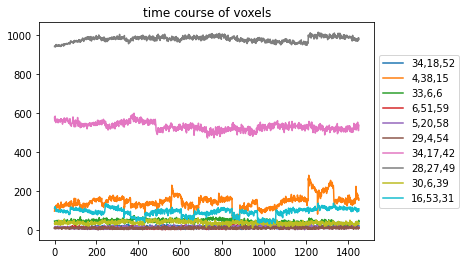

<Figure size 432x288 with 0 Axes>

In [4]:
#plot for 10 random voxels
func_data=functional_img.get_fdata()
for i in range(10):
    x = np.random.randint(0,func_data.shape[0])
    y = np.random.randint(0,func_data.shape[1])
    z = np.random.randint(0,func_data.shape[2])
    plt.plot(func_data[x,y,z],label=f'{x},{y},{z}')
plt.title('time course of voxels')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.figure()



## Q3. 
What is the voxel resolution/dimension of the functional
image? Is it isotropic or anisotropic?

In [5]:
print(functional_img.header['pixdim'])

[1.   3.5  3.75 3.75 2.5  0.   0.   0.  ]


As we see, the dimension of the voxel are not equal in all directions and hence the resolution is anisotropic. 


## Q4. 
List out the categories that are used in the experiments for
visual object recognition task? Plot one image from any of the
two categories.

In [6]:
print(functional_img.affine)

[[  -3.5      0.       0.      68.25 ]
 [   0.       3.75     0.    -118.125]
 [   0.       0.       3.75  -118.125]
 [   0.       0.       0.       1.   ]]


In [7]:
len(haxby_dataset.session_target)

1

In [8]:
session_target = pd.read_csv(haxby_dataset.session_target[0],sep=' ')
print("categories",session_target["labels"].unique())

categories ['rest' 'scissors' 'face' 'cat' 'shoe' 'house' 'scrambledpix' 'bottle'
 'chair']


In [9]:
# haxby_dataset=datasets.fetch_haxby(data_dir=None, fetch_stimuli=True)
haxby_dataset.stimuli.keys()

dict_keys(['faces', 'scissors', 'bottles', 'shoes', 'houses', 'controls', 'cats', 'chairs'])

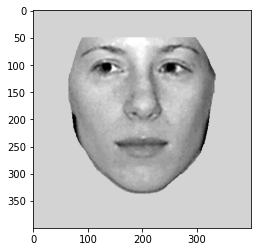

In [10]:
im = plt.imread('/home/avani/nilearn_data/haxby2001/stimuli/faces/Annie_1.jpg')
plt.imshow(im,cmap='gray')

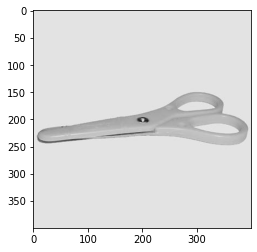

In [11]:
im = plt.imread('/home/avani/nilearn_data/haxby2001/stimuli/scissors/scissor2.2.jpg')
plt.imshow(im,cmap='gray')

## Q5. 
For how many runs/sessions are the experiments repeated?
The information is provided with column name ”chunks” after
loading the .txt file attributed to ”session target”.

In [12]:
behavioral = pd.read_csv(haxby_dataset.session_target[0], delimiter=" ")
behavioral

,labels,chunks
0,rest,0
1,rest,0
2,rest,0
3,rest,0
4,rest,0
...,...,...
1447,rest,11
1448,rest,11
1449,rest,11
1450,rest,11


In [13]:
print('number of unique sessions',len(behavioral["chunks"].unique()))

number of unique sessions 12


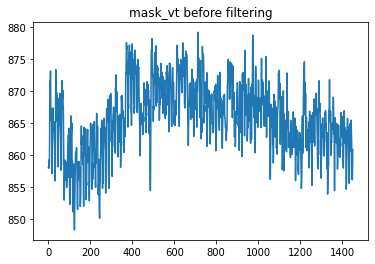

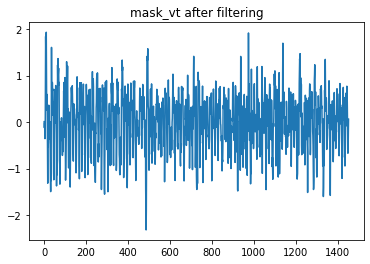

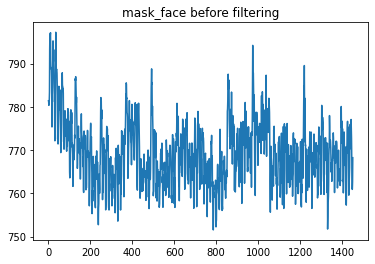

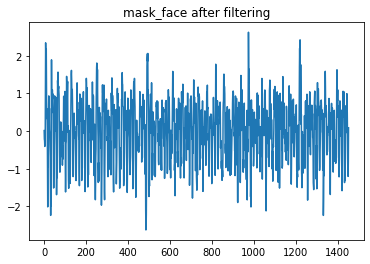

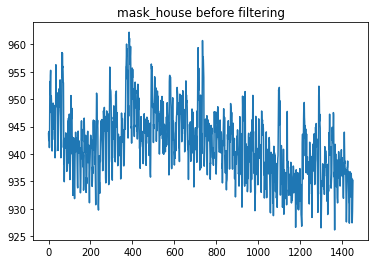

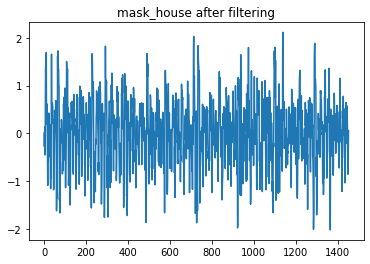

In [17]:
TR = 2.5
def plot(img,title):
    plt.figure()
    plt.plot(img.mean(axis=1))
    plt.title(title)
    
def masking_filtering_plot(mask,k):
    masker = NiftiMasker(mask_img=mask,
                             mask_strategy='epi'
    )
    masked_functional_img = masker.fit_transform(functional_img)
    plot(masked_functional_img,k+' before filtering')
    nifti_masker_filters = NiftiMasker(mask_img =mask, high_pass=0.008,standardize=True, detrend=True,smoothing_fwhm=6, t_r=2.5)
    fmri_filters_applied = nifti_masker_filters.fit_transform(functional_img)
    plot(fmri_filters_applied,k+' after filtering')
    return masked_functional_img,fmri_filters_applied
    
filters = []
masked_imgs = []
lis = ['mask_vt','mask_face','mask_house']
for k in lis:
    masked_functional_img,fmri_filters_applied = masking_filtering_plot(image.load_img(haxby_dataset[k][0]),k)
    filters.append(fmri_filters_applied)
    masked_imgs.append(masked_functional_img)


<Figure size 432x288 with 0 Axes>

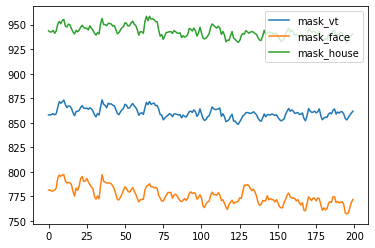

<Figure size 432x288 with 0 Axes>

In [23]:
for i,it in enumerate(lis):
    plt.plot(masked_imgs[i].mean(axis=1)[:200],label=lis[i])
    

plt.legend()
plt.figure()

<Figure size 432x288 with 0 Axes>

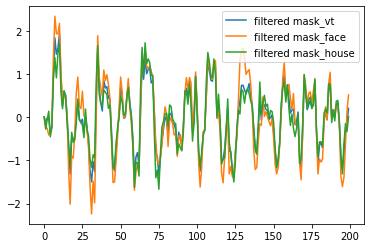

<Figure size 432x288 with 0 Axes>

In [22]:
for i,it in enumerate(lis):
    plt.plot(filters[i].mean(axis=1)[:200],label='filtered '+lis[i])
    
    
plt.legend()
plt.figure()

## Q6.
After plotting the average signals from each of those masks
(each 1D):
– Does the signals appear like a block design or event related
design? <br>
Ans.  Event related design, since they fluctuate a lot.


– From the raw timeseries signals, can you see which stimulus
evoked a larger response? Is it vt or face or house? <br>
Ans. house stimulus

## Q7. 
What are the importance of high pass, standardize, de-
trend such parameters in fMRI time series analysis? Can you
state their role? What could be influencing the results if such
parameters are not specified?

These are used to Improve SNR on masked fMRI signals.

**High pass:**

 High-pass filtering as the name suggests zeros out signals below a certain threshold allowing only the signals above threshold to pass(high pass)
This helps in filering out the low frequency noise drifts in fMRI data.

**Standardize:**

The scale of signals can be varying between various voxels(as we see in Q2) and hence in order to compare acroess voxels for analysis(like in multi-subject) standardizing is useful. 


**Detrend:**

Detrending makes a non-stationary time series to stationary time series.

task:

Make a design matrix X for GLM analysis. Prepare it in the form
of dictionary. We analyze the whole fMRI image by separating
out according to each session, sample screen shot is shown below.
Append the code in below snapshots into a script that was used
to load functional image and session target.

After loading the txt file with Pandas, assign the column ”labels”
into conditions and ”chunks” into sessions to execute the steps
in Figure 4.

In [15]:
conditions = behavioral['labels']
sessions = behavioral['chunks']

In [16]:
## TLDR
conditions_session = conditions[sessions==1]
n_scans = len(conditions_session)
frame_times = TR*np.arange(n_scans)
duration = np.ones(n_scans)*TR

events = pd.DataFrame(
    {
        'onset':frame_times,
        'trial_type':conditions_session,
        'duration':duration
    }
)
events

,onset,trial_type,duration
121,0.0,rest,2.5
122,2.5,rest,2.5
123,5.0,rest,2.5
124,7.5,rest,2.5
125,10.0,rest,2.5
...,...,...,...
237,290.0,rest,2.5
238,292.5,rest,2.5
239,295.0,rest,2.5
240,297.5,rest,2.5


## Q8. 
Observe the difference in the data array shape of conditions
and conditions session? What does that mean? You can print
the shapes of both arrays and tell us why they are different?

In [17]:
print('conditions:',conditions.shape)
print('conditions session:', conditions_session.shape)

conditions: (1452,)
conditions session: (121,)


conditions_session is much smaller than conditions. (121 vs 1452) reason being conditions_session has just one session whereas conditions has all sessions.

In [18]:
## TLDR
from nilearn.glm.first_level import FirstLevelModel
glm = FirstLevelModel(
    t_r=TR,
    mask_img=haxby_dataset['mask'],
    high_pass=0.008,
    smoothing_fwhm=4
)

## Q9. 
Part1. Why is smoothing necessary? 

Ans.

fMRI data has a lot of noise which can be detrimental for analysis. Smoothing helps by reducing this noise and makes it easier to find patterns in data.

Part2. What type of smoothing is implemented in the code?

Ans.
Gaussian kernel with a specification of FWHM

### Q10. 
In the code, what is the role of nilearn.image.index img?

Ans.

It is used for extracting a 3D image out of  4D image.
source: https://nilearn.github.io/modules/generated/nilearn.image.index_img.html

Why is it important to apply on functional image?

Ans. Because fMRI is a 4D image and we extract 3D image using image.index_img. 3D image is used for analysis.

### Q11.
Dig into the FirstLevelModel and helps us understand what
type of regression technique is used to estimate β maps? Which
software is Nilearn dependent on for that regression technique?


Ans.
Linear kernel is used as a regression technique to estimate β maps.

Nilearn uses scikit-learn's Support Vector Classifier.





In [19]:
## TLDR
z_maps = []
conditions_label = []
session_label = []

session = 1

fmri_session = image.index_img(functional_img, sessions == session)

glm.fit(fmri_session, events=events)

conditions = ['face', 'scrambledpix', 'scissors', 'shoe', 'bottle', 'cat', 'chair', 'house']

for condition_ in conditions:
    z_maps.append(glm.compute_contrast(condition_))
    conditions_label.append(condition_)
    session_label.append(session)
    

In [20]:
conditions_label

['face', 'scrambledpix', 'scissors', 'shoe', 'bottle', 'cat', 'chair', 'house']

In [21]:
session_label

[1, 1, 1, 1, 1, 1, 1, 1]

In [22]:
func_filename = haxby_dataset.func[0]

In [23]:
from nilearn.image import mean_img
from nilearn.reporting import make_glm_report
mean_img_ = mean_img(func_filename)
report = make_glm_report(glm,
                         contrasts=conditions,
                         bg_img=mean_img_,
                         )

In [24]:
report

drift_model,cosine
drift_order,1
fir_delays,[0]
high_pass (Hz),0.01
hrf_model,glover
noise_model,ar1
scaling_axis,0
signal_scaling,True
slice_time_ref,0.0
smoothing_fwhm,4
standardize,False


## Q 12
Plot the design matrices attribute using nilearn.plotting.plot design. What does each column represents? Does this makes sense with GLM design that is shown on Figure 2? Briefly elaborate how it made sense to you?


## Part 12.1

In [25]:
design_matrices = make_first_level_design_matrix(frame_times, events,
                          drift_model='polynomial', drift_order=3)

In [26]:
events

,onset,trial_type,duration
121,0.0,rest,2.5
122,2.5,rest,2.5
123,5.0,rest,2.5
124,7.5,rest,2.5
125,10.0,rest,2.5
...,...,...,...
237,290.0,rest,2.5
238,292.5,rest,2.5
239,295.0,rest,2.5
240,297.5,rest,2.5


<AxesSubplot:label='conditions', ylabel='scan number'>

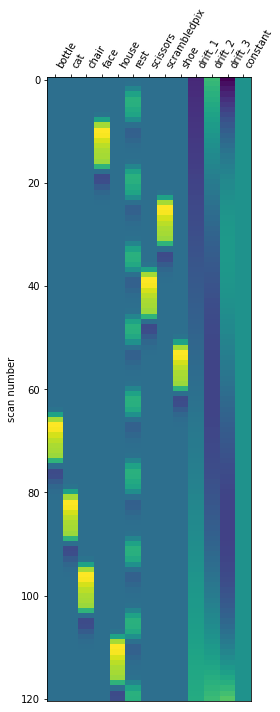

In [27]:

plot_design_matrix(design_matrices)

In [28]:
design_matrices.keys()

Index(['bottle', 'cat', 'chair', 'face', 'house', 'rest', 'scissors',
       'scrambledpix', 'shoe', 'drift_1', 'drift_2', 'drift_3', 'constant'],
      dtype='object')

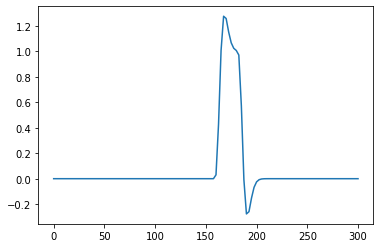

In [29]:
plt.plot(design_matrices['bottle'])
plt.show()

 ### Q12.2
 What does each column represents? 
 Ans. Initial 9 columns represent experimental conditions for different stimulus of images(bottle,cat,etc). The following 3 columns describe low-frequency signals and the last column signifies constant of regression.
 
### Q12.3
Does this makes sense with GLM design that is shown on Figure 2? Briefly elaborate how it made sense to you?

Ans. Matrix-X represents design matrix formed by k temporal regressors of interest. Where regressors tells about occurrence of stimulus in thei experiment.

## Question 13
Scanning length = Time taken for total sessions: 120*2.5 = 300 seconds per session

## Question 14
What is compute contrast? What it does? Plot the compute constrast outputs for all conditions using nilearn.plotting.plot stat map with bg img as Haxby data anatomical image. What is this output type z maps means?

 Ans. 
 Compute contrast is a weighted combination of the estimated effects.
 
It is used to select some columns of the model and potentially weight them for studying the associated statistics.
Output type z-maps means the output is calculated corresponding to the contrast provided by z-map.
 
 


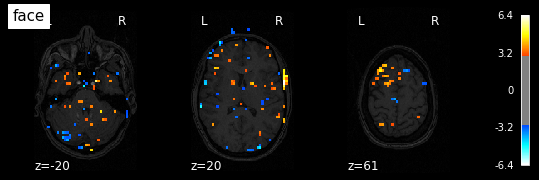

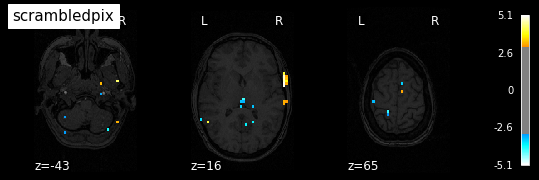

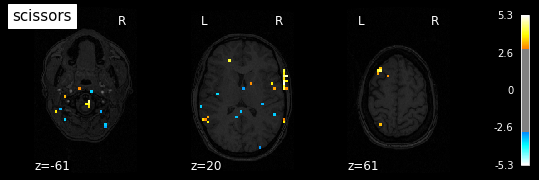

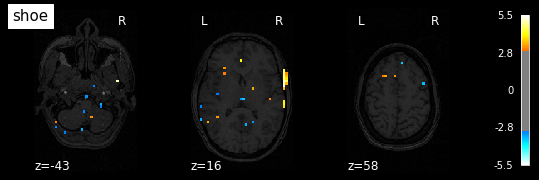

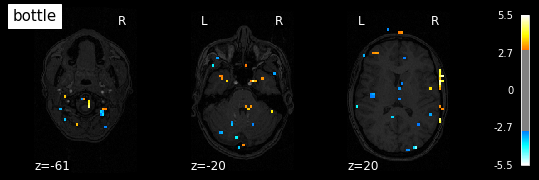

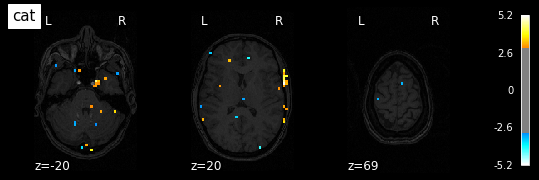

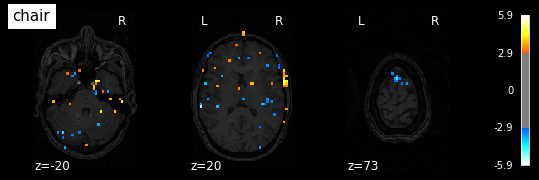

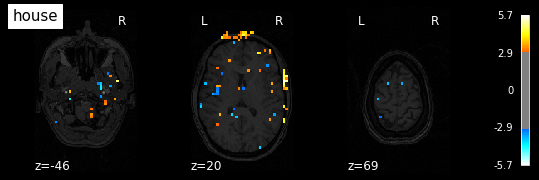

In [30]:

from nilearn.plotting import plot_stat_map
for i in range(len(conditions)):
    
    plot_stat_map(z_maps[i], bg_img=haxby_dataset['anat'][0], threshold=3.0,
              display_mode='z', cut_coords=3, black_bg=True,
              title=conditions[i])
    plt.show()
    

## Running for all sessions

Now, make a complete script and run the script for all sessions.
The script should give us 96 contrast maps (mapped brain re-
sponses to stimuli), conditions label for decoding and sessions
label for leave one session out cross validation.

In [31]:
conditions = behavioral['labels']
sessions = behavioral['chunks']
unique_sessions = sessions.unique()

In [32]:
## TLDR
events_all = {}
for session in unique_sessions:
    conditions_session = conditions[sessions==session]
    n_scans = len(conditions_session)
    frame_times = TR*np.arange(n_scans)
    duration = np.ones(n_scans)*TR

    events_all[session] = pd.DataFrame(
        {
            'onset':frame_times,
            'trial_type':conditions_session,
            'duration':duration
        }
    )


In [33]:
print(len(events_all))

12


In [34]:
print(events_all.keys())

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])


In [35]:
print(events_all[0].shape)

(121, 3)


In [37]:
## TLDR
z_maps = []
conditions_label = []
session_label = []

for session in unique_sessions:

    fmri_session = image.index_img(functional_img, sessions == session)

    glm.fit(fmri_session, events=events)

    conditions = ['face', 'scrambledpix', 'scissors', 'shoe', 'bottle', 'cat', 'chair', 'house']

    for condition_ in conditions:
        z_maps.append(glm.compute_contrast(condition_))
        conditions_label.append(condition_)
        session_label.append(session)


In [39]:
print(len(z_maps), len(conditions_label), len(session_label))

96 96 96


## Decoding: Classifying conditions given brain responses

In [43]:
decoder = Decoder(estimator='svc', mask=haxby_dataset.mask, standardize=False,
                  screening_percentile=5, cv=LeaveOneGroupOut())
decoder.fit(z_maps, conditions_label, groups=session_label)

classification_accuracy = np.mean(list(decoder.cv_scores_.values()))
classification_accuracy

0.724702380952381

## Q15.
Tell us what this example tried to replicate in the paper. Does the classification accuracies per ROI across different categories makes sense with the outcomes of the paper? Convince us by writing a brief paragraph to assess your understanding.


Ans.

In the given examples in https://nilearn.github.io/auto_examples/02_decoding/plot_haxby_full_analysis.html they calculate accuracy on various categories on three different masks: mask_vt, mask_face, mask_house.

Whereas in the paper they analyise only on the mask_vt. The accuracy of a response is determined by comparing patterns produced in the ventral temporal (vt) cortex with patterns induced by presenting other stimuli. It has contrasted the patterns formed by different categories employing home and face masks in the example, in addition to the full ventral stream. 
The findings show that face and object representations in the ventral temporal cortex are extensively dispersed and overlapped. As a result, we achieve high accuracies >50% across all ROI categories.